100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 535kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.62MB/s]


Epoch [1/30] | Loss_D: 0.3507 | Loss_G: 5.7388
Epoch [2/30] | Loss_D: 0.4379 | Loss_G: 3.9603
Epoch [3/30] | Loss_D: 0.5989 | Loss_G: 3.2441
Epoch [4/30] | Loss_D: 0.5357 | Loss_G: 3.7693
Epoch [5/30] | Loss_D: 0.6830 | Loss_G: 3.2958
Epoch [6/30] | Loss_D: 0.7837 | Loss_G: 2.7084
Epoch [7/30] | Loss_D: 0.8148 | Loss_G: 2.0660
Epoch [8/30] | Loss_D: 0.7802 | Loss_G: 1.9167
Epoch [9/30] | Loss_D: 0.8368 | Loss_G: 2.2912
Epoch [10/30] | Loss_D: 1.0673 | Loss_G: 1.7835
Epoch [11/30] | Loss_D: 0.9286 | Loss_G: 1.7859
Epoch [12/30] | Loss_D: 0.7243 | Loss_G: 2.1298
Epoch [13/30] | Loss_D: 1.2665 | Loss_G: 1.6465
Epoch [14/30] | Loss_D: 1.1828 | Loss_G: 1.5001
Epoch [15/30] | Loss_D: 1.0515 | Loss_G: 1.3666
Epoch [16/30] | Loss_D: 1.0771 | Loss_G: 1.1980
Epoch [17/30] | Loss_D: 1.3794 | Loss_G: 1.1805
Epoch [18/30] | Loss_D: 1.2046 | Loss_G: 1.4875
Epoch [19/30] | Loss_D: 1.1914 | Loss_G: 1.3954
Epoch [20/30] | Loss_D: 1.1969 | Loss_G: 1.1216
Epoch [21/30] | Loss_D: 1.1872 | Loss_G: 1.2054
E

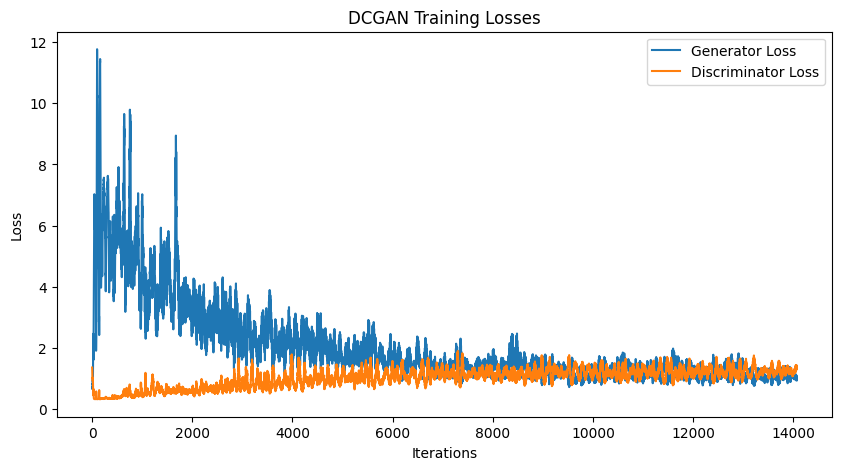

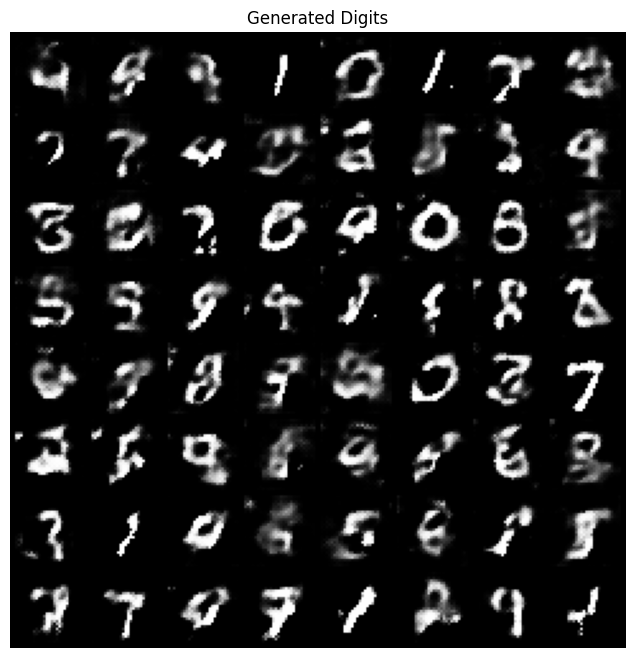

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ✅ Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ✅ Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# ✅ Define ConvGenerator
class ConvGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 7, 1, 0),  # [batch, 256, 7, 7]
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # [batch, 128, 14, 14]
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),    # [batch, 1, 28, 28]
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(-1, 100, 1, 1))

# ✅ Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# ✅ Initialize models, loss, and optimizers
G = ConvGenerator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002)
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002)

# ✅ Track losses
G_losses = []
D_losses = []

# ✅ Training loop
epochs = 30
for epoch in range(epochs):
    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels with smoothing
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # === Train Discriminator ===
        z = torch.randn(batch_size, 100, device=device)
        fake_imgs = G(z)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())

        loss_D_real = loss_fn(D_real, real_labels)
        loss_D_fake = loss_fn(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # === Train Generator ===
        D_fake = D(fake_imgs)
        loss_G = loss_fn(D_fake, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # Save batch losses
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

    print(f"Epoch [{epoch+1}/{epochs}] | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

# ✅ Plot losses after training
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("DCGAN Training Losses")
plt.legend()
plt.show()

# ✅ Optional: Visualize final generated digits
def show_generated_images(model, device, n=64):
    z = torch.randn(n, 100).to(device)
    fake_imgs = model(z).detach().cpu()
    grid = torchvision.utils.make_grid(fake_imgs, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Digits")
    plt.show()

show_generated_images(G, device)
